<a href="https://colab.research.google.com/github/ChristopheMorau/ENSAE_PROJECT_optimal_transport/blob/main/OT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Projection Robust Wassertein distance (PRW) computation with Riemannian gradient ascent with Sinkhorn (RGAS) algorithm and Riemannian adaptive gradient ascent with Sinkhorn (RAGAS) algorithm
* This tutorial is inspired from the paper Projection Robust Wasserstein Distance and Riemannian Optimization, Lin _et al._ (2023).
* This tutorial uses OTT to compute the PRW in the case of simulated distributions of a fragmented hypercube and in the case of real data.
* In this tutorial, choices are made to fine-tune a few hyperparameters with a high impact in terms of convergence of the RGAS and RAGAS algorithms.

## 0. Loading required packages

In [ ]:
!pip install ott-jax
!pip install POT
!git clone https://github.com/francoispierrepaty/SubspaceRobustWasserstein.git
!pip install -U dm-haiku

import sys
import numpy as np
from functools import partial
import statistics
import matplotlib.pyplot as plt
import math
from math import nan
from __future__ import print_function
import argparse
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import jax
from jax import jit
import jax.numpy as jnp

import ot
import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools.sinkhorn_divergence import sinkhorn_divergence

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from scipy.linalg import qr

sys.path.append('/content/SubspaceRobustWasserstein')
from SubspaceRobustWasserstein.SRW import SubspaceRobustWasserstein
from SubspaceRobustWasserstein.Optimization.projectedascent import ProjectedGradientAscent
from SubspaceRobustWasserstein.Optimization.frankwolfe import FrankWolfe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 kB 12.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 17.0 MB/s eta 0:00:00
Cloning into 'SubspaceRobustWasserstein'...
remote: Enumerating objects: 86, done.
remote: Total 86 (delta 0), reused 0 (delta 0), pack-reused 86
Unpacking objects: 100% (86/86), 736.78 KiB | 1.87 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 14.2 MB/s eta 0:00:00
GPU not found.


## 1. Defining base functions
_In this section we define base functions which will prove useful for the implementation of RGAS and RAGAS algorithms to compute PRW._

In [ ]:
# defining coefficient matrix from definition 2.4. of the paper
def compute_C(x, y):

  fun = lambda i,j : jnp.linalg.norm(x[i] - y[j])**2
  mapped = jit(jax.vmap(jax.vmap(fun, in_axes=(None, 0)), in_axes=(0, None)))
  
  return mapped(jnp.arange(len(x)), jnp.arange(len(y)))


# defining correlation matrix from definition 2.5. of the paper
def compute_V(x, y, pi):

  fun = lambda i,j : pi[i,j] * jnp.outer( x[i] - y[j], x[i] - y[j])
  mapped = jit(jax.vmap(jax.vmap(fun, in_axes=(None, 0)), in_axes=(0, None)))
  
  return jnp.sum(mapped(jnp.arange(len(x)), jnp.arange(len(y))), axis=(0, 1))


# defining OT solver
# we assume that epsilon corresponds to the entropic regularization term 
# as documented at https://ott-jax.readthedocs.io/en/latest/solvers/_autosummary/ott.solvers.linear.sinkhorn_lr.LRSinkhorn.html
def reg_OT_solver(x, r, y, c, U, eta, eps_hat):

  geom = ott.geometry.pointcloud.PointCloud( jnp.matmul(x, U) , jnp.matmul(y, U), epsilon=eta) 
  problem = ott.problems.linear.linear_problem.LinearProblem(geom, a = r, b=c)  
  solver = ott.solvers.linear.sinkhorn.Sinkhorn()                   
  out = solver(problem)
  
  return out.matrix                                    


# defining riemannian subdifferential function with remark 2.4 of the paper 
# and the projection formula of G onto TZSt given by Absil et al. [2009, Example 3.6.2]: P TZSt(G) = G − Z(G.T*Z + Z.T*G)/2
def riemannian_subdifferential(grad_f, tangent_point):

  el_1 = jnp.matmul(jnp.transpose(grad_f), tangent_point)
  el_2 = jnp.matmul(jnp.transpose(tangent_point), grad_f)
  
  return grad_f - jnp.matmul(tangent_point, el_1 + el_2)/2


# defining the retraction on the Stiefel manifold based this time on P-A. Absil, R. Mahony, and R. Sepulchre. (2009)
# Optimization Algorithms on Matrix Manifolds. Princeton University Press. 2009
def retraction(projected_point, U):

  to_minus_square = jnp.eye(U.shape[1]) + jnp.matmul( jnp.transpose(projected_point), projected_point)
  eig_val, eig_vect = np.linalg.eig(to_minus_square)
  D_minus_square = jnp.linalg.inv(jnp.sqrt( jnp.diag(eig_val)))
  right_mul = jnp.linalg.inv(eig_vect) @ D_minus_square @ eig_vect
  left_mul = U + projected_point              
  
  return jnp.matmul(left_mul, right_mul) 


# defining stopping criterion with "Computation time" section of part 4 of the paper
def is_stable(U, previous_U, eps):

    unstable = True
    gap = jnp.linalg.norm( U - previous_U, ord='fro') / jnp.linalg.norm( previous_U , ord='fro')
    print(gap)
    if gap < eps:
      unstable = False
    
    return unstable


# defining alternative condition to stop the RGAS and RAGAS algorithms :
# checks whether the 30 last terms are stable or not in terms of standard deviation, with control level std_control_level
# and checks if they are stable around a target value for convergence, with control level neighbourhood_control_level
def stopping_condition2(Ps, std_control_level, neighbourhood_control_level, it, target):
  
  if (it > 30) and (statistics.stdev(Ps[-30:]) < std_control_level) and (abs(np.mean(Ps[-30:]) - target) < neighbourhood_control_level):
    return True
  else:
    return False

## 2. Implemention of a method strongly inspired from the paper to set values of hyperparameters L1 and L2
_We compute L1 and L2 empirically with proposition 2.1 of the paper : L1 and L2 are upper bounds of norms of functions which fundamentally take as input elements of the Stiefel manifold. So we simulate a lot (1000 seems to be enough to obtain a significant estimation) of Stiefel elements and take the max of the norms ratios to retrieve L1 and L2._

In [ ]:
def simulate_stiefel(n, d):

  Q, _ = np.linalg.qr(np.random.randn(n, d))
  
  return Q


def approximate_L1(n, d, num_sim):

  L1_upperBound_values = []

  for i in range(num_sim):

    Z = simulate_stiefel(n, d)
    if n <= d:
      rand_M = np.random.randint(-10, 10,(n, n)) # we set 10 as bound but other values (s.t. 10k or 100k) do not change the final output of L1
    else:
      rand_M = np.random.randint(-10, 10,(n, d))
    ksi = rand_M - Z.dot((rand_M.T).dot(Z) + (Z.T).dot(rand_M))/2
    #print((ksi.T).dot(Z) + (Z.T).dot(ksi)) # should be equal to 0 : OK
    L1_upperBound_values.append(np.linalg.norm(retraction(ksi, Z) - Z, ord='fro')/np.linalg.norm(ksi, ord='fro'))

  L1_upperBound_values = [value for value in L1_upperBound_values if not math.isnan(value)]

  return {'values': L1_upperBound_values, 'max': max(L1_upperBound_values)}


def approximate_L2(n, d, num_sim):
  
  L2_upperBound_values = []

  for i in range(num_sim):
    
    Z = simulate_stiefel(n, d)
    if n <= d:
      rand_M = np.random.randint(-10, 10,(n, n)) # we set 10 as bound but other values (s.t. 10k or 100k) do not change the final output of L2
    else:
      rand_M = np.random.randint(-10, 10,(n, d))
    ksi = rand_M - Z.dot((rand_M.T).dot(Z) + (Z.T).dot(rand_M))/2
    L2_upperBound_values.append(np.linalg.norm(retraction(ksi, Z) - Z - ksi, ord='fro')/np.linalg.norm(ksi, ord='fro')**2)
  
  L2_upperBound_values = [value for value in L2_upperBound_values if not math.isnan(value)]

  return {'values': L2_upperBound_values, 'max': max(L2_upperBound_values)}

_Testing L1 and L2 estimation functions for n = 15, d = 20_

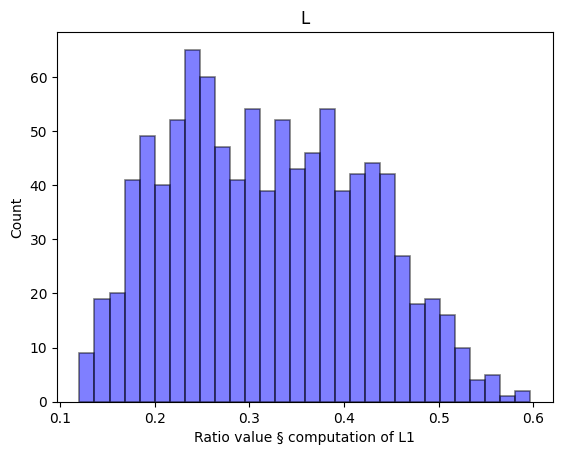

0.596725260908997


In [ ]:
L1 = approximate_L1(10,20, 1000)

plt.hist(L1['values'], bins = 30, alpha=0.5, edgecolor='black', linewidth=1.2, color='blue')
plt.xlabel('Ratio value § computation of L1')
plt.ylabel('Count')
plt.show()
print(L1['max'])

_We see empirically that an upper bound seems to exist, so we take it as value for L1 hyperparameter_

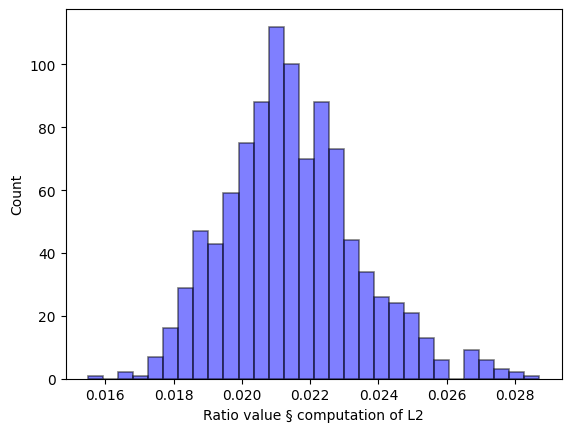

0.028710615214295347


In [ ]:
L2 = approximate_L2(10,20, 1000)

plt.hist(L2['values'], bins = 30, alpha=0.5, edgecolor='black', linewidth=1.2, color='blue')
plt.xlabel('Ratio value § computation of L2')
plt.ylabel('Count')
plt.show()
print(L2['max'])

_We see empirically that an upper bound seems to exist, so we take it as value for L2 hyperparameter_

## 3. Defining RGAS and RAGAS algorithms
_From Theorem 3.9 of the paper, both RGAS and RAGAS algorithms - with adequate choices of hyper-parameters - should converge and return an epsilon-approximate pair of
optimal subspace projection and optimal transportation plan of the computation of the PRW distance._

In [ ]:
# defining RGAS as presented in "algorithm 1" section of the paper, 
# with additional stopping criterion based on the stopping_condition2 function previously defined
# and scaling factor for coefficient matrix C, applied to all the coordinates of C
# The choice of values for hyper-parameters C_scaling_factor, std_control_level, neighbourhood_control_level and target is detailed later 
def RGAS(x, r, y, c, U, eps, 
         C_scaling_factor = 1, 
         stopping_criterion = ['epsilon', 'alternative'], std_control_level = 1, neighbourhood_control_level = 1, target = 0):

  #We start by initiliazing the different parameters with the formulas from the paper. A scaling factor is also applied to all coordinates of C
  C = compute_C(x, y)
  if C_scaling_factor != 1:
    C = jnp.multiply(C, C_scaling_factor)
  eps_hat = eps/(10*jnp.linalg.norm(C, ord=jnp.inf))
  eta = eps * min(1, 1/theta)/(40 * math.log(len(x)))
  gamma = 1/((8*L1**2 + 16*L2)*jnp.linalg.norm(C, ord=jnp.inf) + 16*1/eta      
             * L1**2 * jnp.linalg.norm(C, ord=jnp.inf)**2)
  
  cond = True
  previous_U = U
  it = 0
  Ps = []

  while cond:

    it += 1
    print('\n')
    print('it', it, '|| eps : ')

    #at each iteration, we solve the optimal transport problem with U_t to get pi_t+1, an updated version of the transportation plan
    pi = reg_OT_solver(x, r, y, c, U, eta, eps_hat)

    #Using pi_t+1, we get the Riemannian subdifferential of the function we seek to maximize
    V = compute_V(x, y, pi)
    ksi = riemannian_subdifferential(2*jnp.matmul(V, U), U)
    #It can be checked that the subdifferential ksi belongs as expected to the tangent space at point U: use print('safety check 1: should be 0', jnp.transpose(U) @ ksi + jnp.transpose(ksi) @ U )


    #Applying a retractation on ksi gives U_t+1, an updated version of the subspace projection
    U = retraction(gamma * ksi, U)   
    # It can be checked that U belongs to the Stiefel manifold, as expected: use print('safety check 2 : should be Id', jnp.transpose(U) @ U)  


    #We finally check if we reached an epsilon-approximate of the optimal pi and U
    pi_unstable = is_stable(U, previous_U, eps)
    previous_U = U
    print('P_k : ', P_k(pi, U, x, y))
    Ps.append(float(P_k(pi, U, x, y)))

    #We also apply our alternative stopping criteria
    if len(Ps) > 30:
      std = statistics.stdev(Ps[-30:])
      print('moving std : ', int(10000*std)/10000)
      # computing moving average l-1 distance to target P_k value (on 30 last Ps):
      print('MA dist. to target : ', int(10000*abs(np.mean(Ps[-30:]) - target))/10000)

    if stopping_criterion == ['epsilon', 'alternative']:
      cond = pi_unstable and (stopping_condition2(Ps, std_control_level, neighbourhood_control_level, it, target) is False)
    elif stopping_criterion == ['epsilon']:
      cond = pi_unstable
    elif stopping_criterion == ['alternative']:
      cond = (stopping_condition2(Ps, std_control_level, neighbourhood_control_level, it, target) is False)

  return pi, U, Ps


# defining RAGAS as presented in "algorithm 2" section of the paper, 
# with additional stopping criterion based on the stopping_condition2 function previously defined
# and scaling factor for coefficient matrix C, applied to all the coordinates of C
# Parameters alpha and beta are set to alpha = 10**-6 and beta = 0.8 as in the paper
# The choice of values for hyper-parameters C_scaling_factor, std_control_level, neighbourhood_control_level and target is detailed later 
def RAGAS(x, r, y, c, U, eps, 
          alpha = 10**-6, beta = 0.8, 
          C_scaling_factor = 2.5e-5, 
          stopping_criterion = ['epsilon', 'alternative'], std_control_level = 1, neighbourhood_control_level = 1, target = 0):
  
  #We start by initiliazing the different parameters with the formulas from the paper. A scaling factor is also applied to all coordinates of C
  p = 0
  q = 0
  C = compute_C(x, y)
  p_hat = alpha * jnp.linalg.norm(C, ord=jnp.inf)**2 * jnp.ones(x.shape[1])
  q_hat = alpha * jnp.linalg.norm(C, ord=jnp.inf)**2 * jnp.ones(U.shape[1])
  eps_hat = eps * math.sqrt(alpha)/(20*jnp.linalg.norm(C, ord=jnp.inf))
  eta = eps * min(1, 1/theta)/(40 * math.log(len(x)))
  gamma = alpha/(16*L1**2 + 32*L2 + 32*(1/eta)* L1**2 * jnp.linalg.norm(C, ord=jnp.inf))

  cond = True
  previous_U = U
  it = 0
  Ps = []

  while cond:

    it += 1
    print('\n')
    print('iteration', it)

    #at each iteration, we solve the optimal transport problem with U_t to get pi_t+1, an updated version of the transportation plan
    pi = reg_OT_solver(x, r, y, c, U, eta, eps_hat)

    #Using pi_t+1, we get the Riemannian subdifferential of the function we seek to maximize
    V = compute_V(x, y, pi)
    G = riemannian_subdifferential(2*jnp.matmul(V, U), U)

    #As described in section 3 of the paper, we compute and apply weight vectors to the subdifferential to improve the search direction of the Riemannian gradient ascent procedure
    p = beta*p + (1-beta)*jnp.diagonal( jnp.matmul( G, jnp.transpose(G) ) )/U.shape[1]
    p_hat = jnp.amax( jnp.array([p, p_hat]), axis=0)
    q = beta*q + (1-beta)*jnp.diagonal( jnp.matmul( jnp.transpose(G), G ) )/x.shape[1]
    q_hat = jnp.amax( jnp.array([q, q_hat]), axis=0)
    left_mul = jnp.linalg.inv(jnp.sqrt(jnp.sqrt(jnp.diag(p_hat))))
    right_mul = jnp.linalg.inv(jnp.sqrt(jnp.sqrt(jnp.diag(q_hat))))
    ksi = riemannian_subdifferential(left_mul @ G @ right_mul, U)
    #It can be checked that the subdifferential ksi belongs as expected to the tangent space at point U: use print('safety check 1: should be 0', jnp.transpose(U) @ ksi + jnp.transpose(ksi) @ U )
    

    #Applying a retractation on ksi gives U_t+1, an updated version of the subspace projection
    U = retraction(gamma * ksi, U)
    # It can be checked that U belongs to the Stiefel manifold, as expected: use print('safety check 2 : should be Id', jnp.transpose(U) @ U)  


    #We finally check if we reached an epsilon-approximate of the optimal pi and U
    pi_unstable = is_stable(U, previous_U, eps)
    previous_U = U
    print('P_k : ', P_k(pi, U, x, y))
    Ps.append(float(P_k(pi, U, x, y)))

    #We also apply our alternative stopping criteria
    if len(Ps) > 30:
      std = statistics.stdev(Ps[-30:])
      print('moving std : ', int(10000*std)/10000)
      # computing moving average l-1 distance to target P_k value (on 30 last Ps):
      print('MA dist. to target : ', int(10000*abs(np.mean(Ps[-30:]) - target))/10000)

    if stopping_criterion == ['epsilon', 'alternative']:
      cond = pi_unstable and (stopping_condition2(Ps, std_control_level, neighbourhood_control_level, it, target) is False)
    elif stopping_criterion == ['epsilon']:
      cond = pi_unstable
    elif stopping_criterion == ['alternative']:
      cond = (stopping_condition2(Ps, std_control_level, neighbourhood_control_level, it, target) is False)

  return pi, U, Ps

## 4. Testing RGAS and RAGAS algorithms on a fragmented hypercube
_µ = U([−1, 1]d
) which is an uniform distribution over an hypercube and
ν = T#µ which is the push-forward of µ under the map T defined in the paper. We want to find sets of hyper-parameters such that RGAS and RAGAS converge to P2k(µ, ν) = 4k* = W2(µ, ν)^2, the squared Wasserstein-2 distance between distributions µ and ν._

In [ ]:
# defining the uniform sampler which simulates fragmented hypercube distributions µ and ν
def uniform_sampler(key):

  keys = jax.random.split(key, num = d)

  #x corresponds to samples of µ, a U([-1, 1]^d) distribution
  x = jax.vmap(jax.random.uniform, in_axes = (0))(jax.random.split(key, num = d))
  x = 2 * x -1

  #y corresponds to samples of ν and is obtained by applying the map T (defined in section 4 of the paper) to x
  symmetric_product = jnp.multiply(jnp.array([1 if k<k_star else 0 for k in range(d) ]), jnp.sign(x)) 
  y = x + 2 * symmetric_product
  
  return x, y


class Uniform_sampler:

    def __init__(self ):
        self.setup()

    def setup(self):
        @partial(jit, static_argnums=1)
        def generate_samples(key, num_samples):
            x, y = jax.vmap(uniform_sampler, in_axes= (0))(jax.random.split(key, num=num_samples))

            return x, y

        self.generate_samples = generate_samples


# defining the P_k^2, it is the PRW distance between x and y that we get for a given transportation plan pi and subspace projection U
# It will be compared to S_k^2 from SRW and W_2^2 from 2-Wasserstein distance
def P_k(pi, U, x, y):
  
  fun = lambda i,j : pi[i,j]*jnp.linalg.norm( jnp.transpose(U) @ x[i] - jnp.transpose(U) @ y[j])**2
  mapped = jit(jax.vmap(jax.vmap(fun, in_axes=(None, 0)), in_axes=(0, None)))
  
  return jnp.sum(mapped(jnp.arange(len(x)),jnp.arange(len(x))))

### In the cell below we run RGAS
* With hyper-parameters __std_control_level = 1, neighbourhood_control_level = 1__ (these values work fine to capture the convergence of the algorithm) and __target = 4k*__. 
* With __different values for C_scaling_factor : 2.5e-5 quickly appears to be a good compromise__ between a fast-but-possibly-unstable convergence towards the desired target (risk of oscillation increases very fast when choosing lower values for scaling) and a very-smooth-but-possibly-never-converging evolution (risk with higher values).

> Results with that setting for 4 different k* scenarii :
* k* = 2 : convergence after 50 iterations (see plot below)
* k* = 4 : convergence after 40 iterations (see plot below)
* k* = 7 : convergence after 40 iterations (see plot below)
* k* = 8 : convergence after 50 iterations (see plot below)


In [ ]:
# fragmented hypercube basic setting
n = 100
d = 15

C_scaling_factor = 2.5e-5 #@param {'type':'number'}
# k_star = 2 #@param {'type':'number'}
k_stars = [2, 4, 7, 8]

for k_star in k_stars:
  target_sampler = Uniform_sampler()
  rng = jax.random.PRNGKey(0)

  x, y = target_sampler.generate_samples(rng, n)
  r = jnp.ones(n)/n
  c = jnp.ones(n)/n

  # fixed hyperparameters of the model
  epsilon = 0.001
  num_sim = 1000
  L1 = approximate_L1(n, d, num_sim)['max']
  L2 = approximate_L2(n, d, num_sim)['max']
  theta = 1 # we tried other values but without much improvement seemingly

  # INITIALIZATION / we generate a matrix from the stiefel manifold using QR decomposition
  A = jax.random.uniform(rng, (d, k_star))
  U, R = jnp.linalg.qr(A)

  pi, U, Ps = RGAS(x, r, y, c, U, epsilon, 
                  C_scaling_factor = C_scaling_factor, 
                  std_control_level = 1, 
                  neighbourhood_control_level = 1, 
                  target = 4*k_star)
  globals()[f"Ps_{k_star}"]= Ps



it 1 || eps : 
0.030017208
P_k :  0.10385716


it 2 || eps : 
0.04150195
P_k :  0.15307766


it 3 || eps : 
0.023519885
P_k :  0.11984501


it 4 || eps : 
0.026400205
P_k :  0.1441604


it 5 || eps : 
0.026856402
P_k :  0.15499885


it 6 || eps : 
0.026064705
P_k :  0.15698192


it 7 || eps : 
0.024575107
P_k :  0.15628359


it 8 || eps : 
0.020593803
P_k :  0.1487518


it 9 || eps : 
0.021911874
P_k :  0.16107184


it 10 || eps : 
0.024163019
P_k :  0.17224295


it 11 || eps : 
0.028073773
P_k :  0.18789625


it 12 || eps : 
0.038737506
P_k :  0.23795663


it 13 || eps : 
0.036731895
P_k :  0.23474523


it 14 || eps : 
0.03864661
P_k :  0.26370502


it 15 || eps : 
0.04564128
P_k :  0.3114842


it 16 || eps : 
0.06457728
P_k :  0.453302


it 17 || eps : 
0.08073076
P_k :  0.6428395


it 18 || eps : 
0.121590294
P_k :  1.1556833


it 19 || eps : 
0.24920933
P_k :  3.444133


it 20 || eps : 
0.35911041
P_k :  6.399727


it 21 || eps : 
0.3334671
P_k :  7.3093576


it 22 || eps : 
0.33

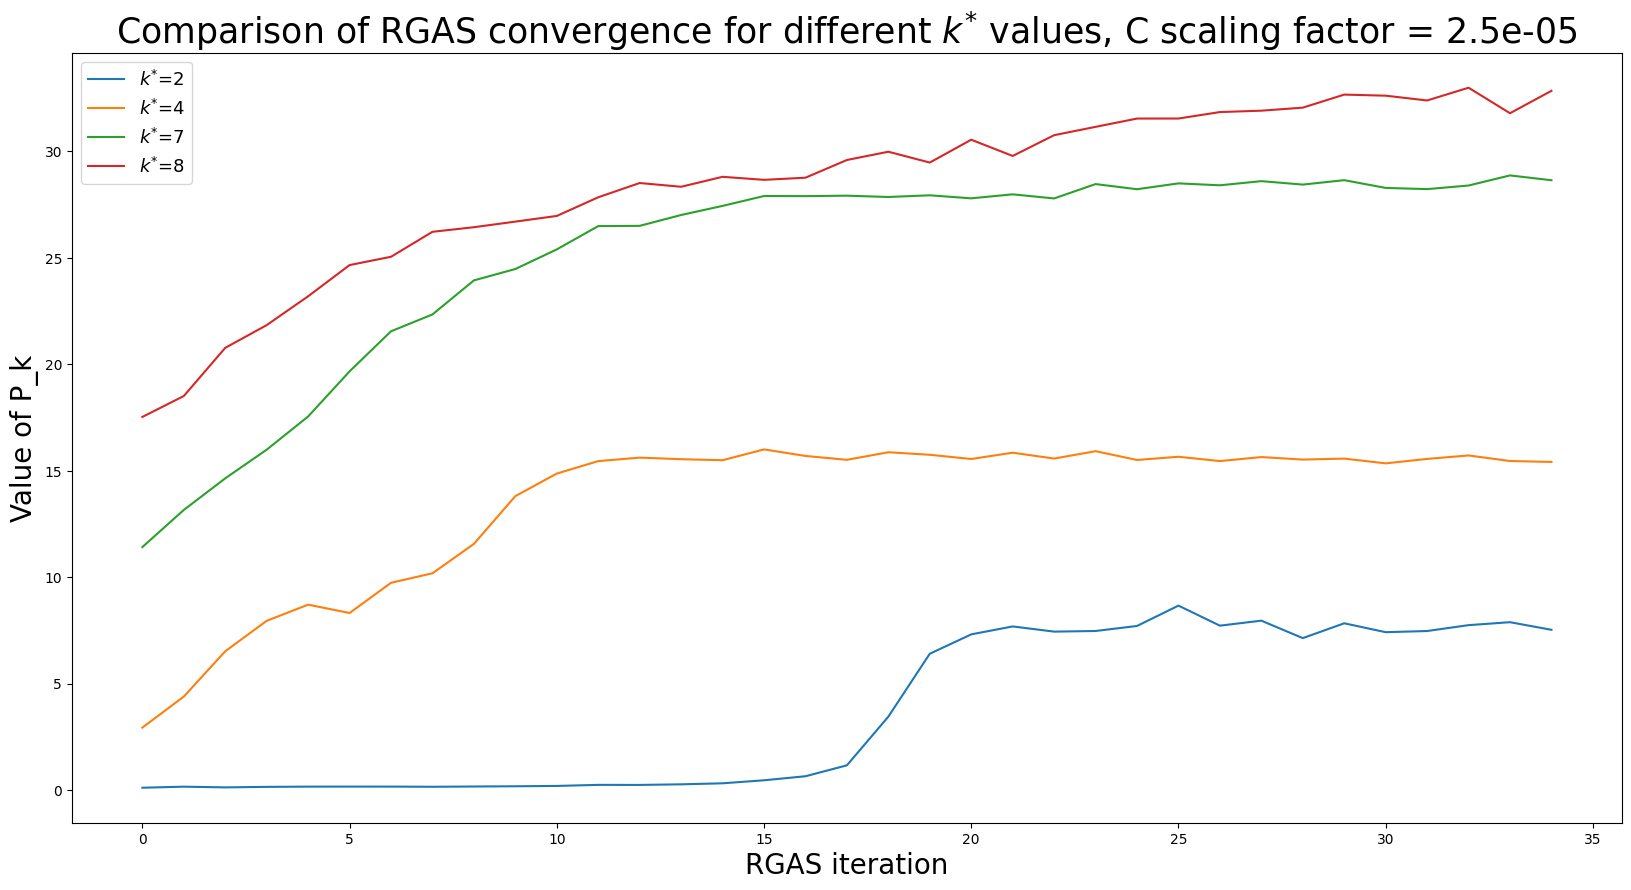

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))
# ax.set_ylim([0, max(Ps) + 1])
max_number = 35
for k_star in k_stars:
  ax.plot([i for i in range(max_number)], globals()[f"Ps_{k_star}"][:max_number], label = "$k^{*}$="+str(k_star))
ax.set_xlabel('RGAS iteration', fontdict={'fontsize': 20})
ax.set_ylabel('Value of P_k',  fontdict={'fontsize': 20})
ax.set_title("Comparison of RGAS convergence for different $k^{*}$ values, C scaling factor = "+str(C_scaling_factor),  fontdict={'fontsize': 25})
plt.legend(fontsize=13)
C_scaling_factor = 0.000025
plt.savefig(f"Comparison of RGAS convergence for different k values, scaling_factor_small")

### In the cell below we run RAGAS
* As in RGAS, with hyper-parameters __std_control_level = 1, neighbourhood_control_level = 1__ and __target = 4k*__. 
* With __different values for L1 and L2, which are the hyper-parameters to which the output is highly sensitive given the formula of gamma : L1 = L2 = 2.5e-8 appears to be the most adequate value such that RAGAS is stable even for small k* values.__

> Results with that setting for 4 different k* scenarii :
* k* = 2 : convergence after 80 iterations (see plot below)
* k* = 4 : convergence after 50 iterations (see plot below)
* k* = 7 : convergence after 50 iterations (see plot below)
* k* = 8 : convergence after 100 iterations (see plot below)


In [ ]:
# fragmented hypercube parameters
n = 100
d = 15
#k_star = 8 #@param {'type':'number'}
k_stars = [2, 4, 7, 8]
for k_star in k_stars:
  target_sampler = Uniform_sampler()
  rng = jax.random.PRNGKey(0)

  x, y = target_sampler.generate_samples(rng, n)
  r = jnp.ones(n)/n
  c = jnp.ones(n)/n

  # fixed hyperparameters of the model
  epsilon = 0.001
  num_sim = 1000
  theta = 1

  # INITIALIZATION / we generate a matrix from the stiefel manifold using QR decomposition
  A = jax.random.uniform(rng, (d, k_star))
  U, R = jnp.linalg.qr(A)

  # setting values for L1 and L2 :
  L1 = 2.5e-8 #@param {'type':'number'}
  L2 = 2.5e-8 #@param {'type':'number'}



  pi, U, Ps = RAGAS(x, r, y, c, U, epsilon, 
                    std_control_level = 1, 
                    neighbourhood_control_level = 1, 
                    target = 4*k_star)
  globals()[f"Ps_{k_star}"] = Ps



iteration 1
0.010653165
P_k :  0.0845321


iteration 2
0.012640248
P_k :  0.09402671


iteration 3
0.014814205
P_k :  0.10376449


iteration 4
0.016068248
P_k :  0.12163968


iteration 5
0.009521951
P_k :  0.116632074


iteration 6
0.00834307
P_k :  0.11713493


iteration 7
0.008518478
P_k :  0.11992392


iteration 8
0.008552331
P_k :  0.12502511


iteration 9
0.007680287
P_k :  0.12246418


iteration 10
0.007486972
P_k :  0.12517531


iteration 11
0.008174046
P_k :  0.13188216


iteration 12
0.008687493
P_k :  0.1408196


iteration 13
0.008878304
P_k :  0.14356461


iteration 14
0.009678489
P_k :  0.14699419


iteration 15
0.009261887
P_k :  0.1484586


iteration 16
0.00821793
P_k :  0.1455799


iteration 17
0.00787735
P_k :  0.1499116


iteration 18
0.008400496
P_k :  0.15409173


iteration 19
0.008171562
P_k :  0.14518863


iteration 20
0.007583523
P_k :  0.14613667


iteration 21
0.007337494
P_k :  0.14759204


iteration 22
0.0074315136
P_k :  0.14721337


iteration 23
0.00834880

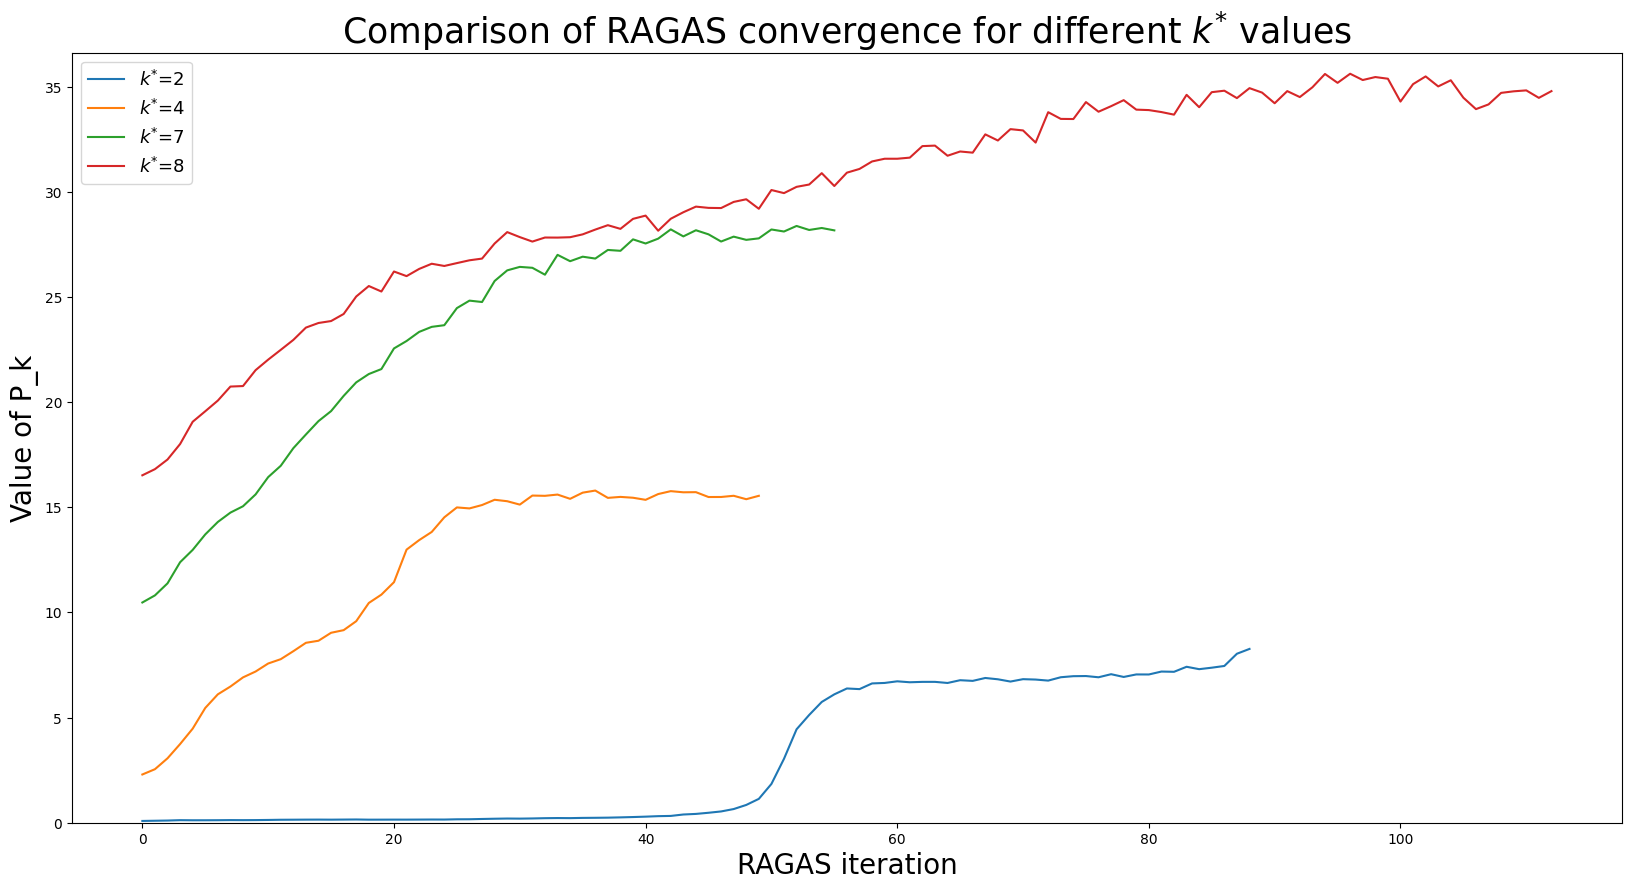

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))

max_number = 35
for k_star in k_stars:
  ax.set_ylim([0, max(globals()[f"Ps_{k_star}"]) + 1])
  ax.plot([i for i in range(len(globals()[f"Ps_{k_star}"]))], globals()[f"Ps_{k_star}"], label = "$k^{*}$="+str(k_star))
ax.set_xlabel('RAGAS iteration', fontdict={'fontsize': 20})
ax.set_ylabel('Value of P_k',  fontdict={'fontsize': 20})
ax.set_title("Comparison of RAGAS convergence for different $k^{*}$ values",fontdict={'fontsize': 25})
plt.legend(fontsize=13)
plt.savefig(f"Comparison of RAGAS convergence for different k values, baseline_values_L1_L2")

## 5. Evaluating performances of RGAS and RAGAS by comparing PRW distance to the Wasserstein-2 distance and the subspace robust Wasserstein (SRW) distance in the fragmented hypercube setting
_Despite non-convexity of PRW, its computation with RGAS and RAGAS using Riemannian optimization can be done efficiently (according to the paper) and could yield better results than convex SRW distance in some cases._

In [ ]:
# Defining Wasserstein-2 distance: we use the POT package to find the optimal transportation plan and the cost associated to it
def W_2(x, r, y, c):
  
  C = compute_C(x, y)
  optimal_plan = ot.emd(r, c, C)
  optimal_cost = np.trace(np.transpose(optimal_plan) @ C)

  return optimal_cost

In [ ]:
# Defining SRW distance: we use the SubspaceRobustWasserstein package with the FrankWolfe algorithm
def SRW(x, r, y, c):

  n = len(x)
  ones = np.ones((n,n))
  C_bis = np.diag(np.diag(x.dot(x.T))).dot(ones) + ones.dot(np.diag(np.diag(y.dot(y.T)))) - 2*x.dot(y.T)

  step_size_0 = 1./np.max(C_bis)

  params = {'reg':0.15, 'step_size_0':step_size_0, 'max_iter':100, 'threshold':0.01,
            'max_iter_sinkhorn':100, 'threshold_sinkhorn':1e-3, 'use_gpu':False}

  algo = FrankWolfe(**params)

  SRW_FW = SubspaceRobustWasserstein(x, y, r, c, algo, k = k_star)
  SRW_FW.run()

  return SRW_FW.get_value()

_In the following cell we retrieve W2, SRW and PRW distances for distinct k* scenarii (k* varying from 2 to 12) :_

In [ ]:
# initialization of distances lists for later use
RGAS_PRW_distances = []
RAGAS_PRW_distances = []
W2_distances = []
SRW_distances = []

# basic hyper-parameters setting
n = 100
d = 15
epsilon = 0.001
num_sim = 1000
L1 = approximate_L1(n, d, num_sim)['max']
L2 = approximate_L2(n, d, num_sim)['max']
theta = 1


# running W2, SRW and PRW with RGAS
for k_star in range(2, 13):

  target_sampler = Uniform_sampler()
  rng = jax.random.PRNGKey(0)
  x, y = target_sampler.generate_samples(rng, n)
  r = jnp.ones(n)/n
  c = jnp.ones(n)/n

  SRW_distances.append(SRW(x, r, y, c)) # computing SRW
  W2_distances.append(float(W_2(x, r, y, c))) # computing W2

  # computing PRW with RGAS :
  A = jax.random.uniform(rng, (d, k_star))
  U, R = jnp.linalg.qr(A)

  pi, U, _ = RGAS(x, r, y, c, U, epsilon, 
                  C_scaling_factor = 2.5e-5, 
                  std_control_level = 1, neighbourhood_control_level = 1.35, # we loosen the control from 1 to 1.35 to save some time
                  target = 4*k_star)
  RGAS_PRW_distances.append(float(P_k(pi, U, x, y)))
  

# computing PRW with RAGAS (separately because hard setting of L1 and L2, but does not add computation time) :
L1 = 2.5e-8
L2 = 2.5e-8

for k_star in range(2, 13):

  target_sampler = Uniform_sampler()
  rng = jax.random.PRNGKey(0)
  x, y = target_sampler.generate_samples(rng, n)
  r = jnp.ones(n)/n
  c = jnp.ones(n)/n

  A = jax.random.uniform(rng, (d, k_star))
  U, R = jnp.linalg.qr(A)

  pi, U, _ = RAGAS(x, r, y, c, U, epsilon, 
                    std_control_level = 1, neighbourhood_control_level = 1.35, # we loosen the control from 1 to 1.35 to save some time
                    target = 4*k_star)
  RAGAS_PRW_distances.append(float(P_k(pi, U, x, y)))

RGAS_K_ = 2


/usr/local/lib/python3.9/dist-packages/ot/backend.py:1308: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jax.device_put(jnp.array(1, dtype=jnp.float64), d)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.


it 19 || eps : 
0.02165804
P_k :  45.93304


it 20 || eps : 
0.021164542
P_k :  45.992344


it 21 || eps : 
0.019620854
P_k :  46.258106


it 22 || eps : 
0.019586863
P_k :  48.029724


it 23 || eps : 
0.018529112
P_k :  48.13248


it 24 || eps : 
0.017030217
P_k :  47.718246


it 25 || eps : 
0.016598182
P_k :  48.507233


it 26 || eps : 
0.014073596
P_k :  47.624706


it 27 || eps : 
0.013414393
P_k :  48.821663


it 28 || eps : 
0.0114910295
P_k :  48.15274


it 29 || eps : 
0.010585344
P_k :  49.012314


it 30 || eps : 
0.009339157
P_k :  48.561756


it 31 || eps : 
0.008306753
P_k :  48.770065
moving std :  7.8115
MA dist. to target :  5.1646


it 32 || eps : 
0.0072898422
P_k :  48.568886
moving std :  7.285
MA dist. to target :  5.9556


it 33 || eps : 
0.006415865
P_k :  48.71927
moving std :  6.7339
MA dist. to target :  6.7109


it 34 || eps : 
0.005680757
P_k :  48.808716
moving std :  6.1373
MA 

_Comparing W2, SRW and PRW computed resp. with RGAS and RAGAS on fragmented hypercube setting :_

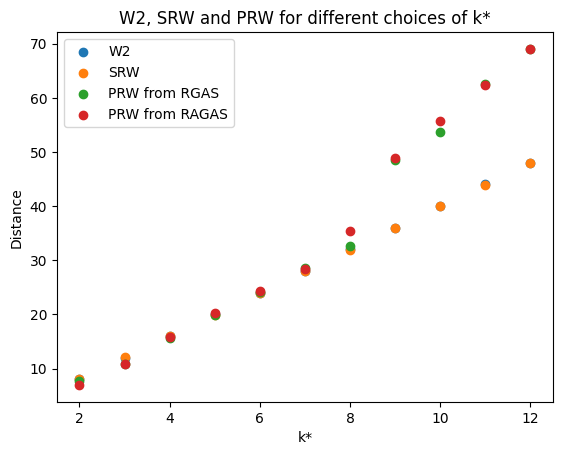

In [ ]:
x = [k for k in range(2, 13)]

plt.scatter(x, W2_distances, label = 'W2')
plt.scatter(x, SRW_distances, label = 'SRW')
plt.scatter(x, RGAS_PRW_distances, label = 'PRW from RGAS')
plt.scatter(x, RAGAS_PRW_distances, label ='PRW from RAGAS')

plt.xlabel('k*')
plt.ylabel('Distance')
plt.title('W2, SRW and PRW for different choices of k*')
plt.legend()
plt.show()

__First remark__ : we can validate the fact that SRW and W2 are equivalent, since blue and orange points always coincide.

__Second remark__ : We see that for $k^*$ lower or equal than 7, PRW from RGAS and RAGAS are consistent with W2 and SRW. Yet, it seems that when $k^*$ gets greater than 8, PRW from RGAS and RAGAS diverges from SRW and W2: this may be evidence that PRW is only suited for high-dimensional settings.

## 6. Practical application to MNIST
_In this part we want to measure the optimal way to transport the shape of a figure into the shape of another figure. For instance, we choose to see if there is any difference between the transport of a 0 into a 1 and the transport of a 0 into an 8: we expect the distance between a 0 and a 8 to be lower than the distance between a 0 and a 1. We can use the OT setting and compare in this real data situation PRW with W2 and SRW._

In [ ]:
# defining the net to capture figure signal and its training and testing functions
# As in the paper, we build on an existing pytorch implementation for the CNN: https://github.com/pytorch/examples/blob/main/mnist/main.py
# We train it and quickly reach a 99% accuracy on MNIST classification

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args['dry_run']:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
  # Training settings
  args = {}
  args['batch_size'] = 64
  args['test_batch_size'] = 1000
  args['epochs'] = 5 # five epochs are enough to achieve high accuracy on train dataloader
  args['lr'] = 1
  args['gamma'] = 0.7
  args['no_cuda'] = False
  args['no_mps'] = False
  args['dry_run'] = False
  args['seed'] = 1
  args['log_interval'] = 10

  use_cuda = torch.cuda.is_available()
  use_mps = torch.backends.mps.is_available()
  torch.manual_seed(args['seed'])

  if use_cuda:
      device = torch.device("cuda")
  elif use_mps:
      device = torch.device("mps")
  else:
      device = torch.device("cpu")

  train_kwargs = {'batch_size': args['batch_size']}
  test_kwargs = {'batch_size': args['test_batch_size']}
  
  if use_cuda:
      cuda_kwargs = {'num_workers': 1,
                      'pin_memory': True,
                      'shuffle': True}
      train_kwargs.update(cuda_kwargs)
      test_kwargs.update(cuda_kwargs)

  transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,))
      ])
  dataset1 = datasets.MNIST('../data', train=True, download=True,
                      transform=transform)
  dataset2 = datasets.MNIST('../data', train=False,
                      transform=transform)
  train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
  test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

  model = Net().to(device)
  optimizer = optim.Adadelta(model.parameters(), lr=args['lr'])

  scheduler = StepLR(optimizer, step_size=1, gamma=args['gamma'])
  for epoch in range(1, args['epochs'] + 1):
      train(args, model, device, train_loader, optimizer, epoch)
      test(model, device, test_loader)
      scheduler.step()

  return model

# training model weights
model = main()

100%|██████████| 9912422/9912422 [00:00<00:00, 97017107.49it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 82349214.02it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41183179.88it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13084154.37it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.282550
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.385087
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.907942
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.627439
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.403565
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.469339
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.288755
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.800061
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.232629
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.321339
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.299994
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.187760
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.332707
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.158527
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.273070
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.177760
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.258602
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.247304
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.255831
Tr

_Loading the figures images data_

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset2 = datasets.MNIST('../data', train=False, download=True,
                       transform=transform)

Reusing the pretrained CNN to turn images into $\mathbf{R}^{128}$ embeddings

In [ ]:
class Emb(nn.Module):
    def __init__(self, model_emb):
      super(Emb, self).__init__()
      self.layers = model_emb
    
    def forward(self, x):
      x = self.layers[0](x)
      x = F.relu(x)
      x = self.layers[1](x)
      x = F.relu(x)
      x = F.max_pool2d(x, 2)
      x = torch.flatten(x, 1)
      x = self.layers[4](x)
      x = F.relu(x)
      return x

# def embedding(dig):
#   """Computes in parallel all the embeddings for digits from 0 to 1""" 
#   idx = torch.argwhere(dataset2.targets == 0)
#   instances = dataset2.data[idx][:100]
#   out = emb(instances.type(torch.float).to(device))
#   return jnp.asarray(out.cpu().detach().numpy())

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = model.eval()
model_emb = nn.Sequential(*[list(net.children())[i] for i in range(5)])
emb = Emb(model_emb).to(device).eval()

# embeddings = jit(jax.vmap(embedding, in_axes=0))(jnp.arange(10))

### Evaluating OT between 0 and 1 with size 128 embeddings 
(=> high-dim. setting when sample size n = 100) 

_We compute W2 first_

In [ ]:
#We filter MNIST on images representing a 0 and turn them into R^128 vectors representations
idx = (dataset2.targets==0) 
zeros = dataset2.data[idx]
out = emb(zeros.type(torch.float).unsqueeze(1).to(device))

#We filter MNIST on images representing a 1 and turn them into R^128 vectors representations
idx = (dataset2.targets==1) 
ones = dataset2.data[idx]
out_ones = emb(ones.type(torch.float).unsqueeze(1).to(device))

#We only keep the first 100 samples
x = jnp.asarray(out[:100].cpu().detach().numpy())
y = jnp.asarray(out_ones[:100].cpu().detach().numpy())

#We apply uniform weights to each sample
r = jnp.ones(100)/100
c = r

#For computational reasons, the data is normalized by 500. 
#We can do it because we are interested in the relative values of the distances (between couple of figures or between methods of computation)
print('W2 = ', float(W_2(x/5e2, r, y/5e2, c)))   

W2 =  20.56400489807129


_Computation of SRW_

__NB__ : in case you get RunTimeError raised please try to increase 'reg' parameter below.

In [ ]:
n = x.shape[0]
ones = np.ones((n,n))
C_bis = np.diag(np.diag(x.dot(x.T))).dot(ones) + ones.dot(np.diag(np.diag(y.dot(y.T)))) - 2*x.dot(y.T)

step_size_0 = 1./np.max(C_bis)

params = {'reg':1e2, 'step_size_0':step_size_0, 'max_iter':100, 'threshold':0.01,
          'max_iter_sinkhorn':100, 'threshold_sinkhorn':1e-3, 'use_gpu':False}

algo = FrankWolfe(**params)

SRW_FW = SubspaceRobustWasserstein(x/5e2, y/5e2, r, c, algo, k=50)
SRW_FW.run()

print('SRW =', SRW_FW.get_value())

SRW = 21.226753


__Remark : W2 and SRW should coincide more or less.__

_Computation of PRW with RGAS_

In [ ]:
n = x.shape[0]
d = x.shape[1]
k_star = 50
rng = jax.random.PRNGKey(0)

# hyperparameters of the model
epsilon = 0.001
num_sim = 1000
L1 = approximate_L1(n, d, num_sim)['max']
L2 = approximate_L2(n, d, num_sim)['max']
theta = 1

# INITIALIZATION / we generate a matrix from the stiefel manifold using QR decomposition
A = jax.random.uniform(rng, (d, k_star))
U, R = jnp.linalg.qr(A)

pi, U, Ps = RGAS(x/5e2, r, y/5e2, c, U, epsilon, 
                 C_scaling_factor = 2.5e-5, 
                 stopping_criterion = ['epsilon'])



it 1 || eps : 
0.0023315179
P_k :  8.198955


it 2 || eps : 
0.002338118
P_k :  8.470894


it 3 || eps : 
0.0023887444
P_k :  8.94314


it 4 || eps : 
0.002343205
P_k :  9.104354


it 5 || eps : 
0.0022865895
P_k :  9.171919


it 6 || eps : 
0.0022700336
P_k :  9.3720875


it 7 || eps : 
0.0023733063
P_k :  10.098079


it 8 || eps : 
0.0023165792
P_k :  10.158051


it 9 || eps : 
0.0022521773
P_k :  10.179125


it 10 || eps : 
0.002216909
P_k :  10.329395


it 11 || eps : 
0.0022853168
P_k :  10.933009


it 12 || eps : 
0.0023007907
P_k :  11.36795


it 13 || eps : 
0.002258401
P_k :  11.519069


it 14 || eps : 
0.0021670356
P_k :  11.418728


it 15 || eps : 
0.0021345706
P_k :  11.601173


it 16 || eps : 
0.0021257
P_k :  11.902703


it 17 || eps : 
0.0020773828
P_k :  12.020334


it 18 || eps : 
0.002081455
P_k :  12.427164


it 19 || eps : 
0.0020222594
P_k :  12.507587


it 20 || eps : 
0.0019814253
P_k :  12.6896


it 21 || eps : 
0.0019426687
P_k :  12.877275


it 22 || eps : 


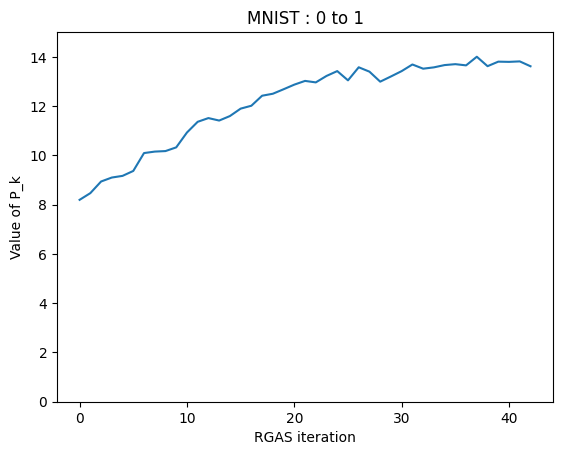

In [ ]:
# plotting the evolution of P_k throughout the iterations of RGAS /
fig, ax = plt.subplots()
ax.set_ylim([0, max(Ps) + 1])
ax.plot([i for i in range(len(Ps))], Ps)
plt.xlabel('RGAS iteration')
plt.ylabel('Value of P_k')
plt.title('MNIST : 0 to 1')
plt.show()

_Computation of PRW with RAGAS_

In [ ]:
# fragmented hypercube parameters
n = x.shape[0]
d = x.shape[1]
k_star = 50
rng = jax.random.PRNGKey(0)

# hyperparameters of the model
epsilon = 0.001
num_sim = 1000
L1 = 6e-8
L2 = 6e-8
theta = 1 

# INITIALIZATION / we generate a matrix from the stiefel manifold using QR decomposition
A = jax.random.uniform(rng, (d, k_star))
U, R = jnp.linalg.qr(A)

pi, U, Ps = RAGAS(x/5e2, r, y/5e2, c, U, epsilon)



iteration 1
0.009291372
P_k :  8.894117


iteration 2
0.009064303
P_k :  9.779066


iteration 3
0.008969287
P_k :  10.7439995


iteration 4
0.008877796
P_k :  11.918285


iteration 5
0.008484832
P_k :  12.81941


iteration 6
0.007661484
P_k :  13.267658


iteration 7
0.00677013
P_k :  13.41316


iteration 8
0.006134734
P_k :  13.8467045


iteration 9
0.005413415
P_k :  13.964647


iteration 10
0.004790645
P_k :  14.093643


iteration 11
0.004268729
P_k :  14.306618


iteration 12
0.0038533246
P_k :  14.750388


iteration 13
0.0032591189
P_k :  14.26878


iteration 14
0.0029269794
P_k :  14.59804


iteration 15
0.0025108038
P_k :  14.229391


iteration 16
0.0023002587
P_k :  14.796905


iteration 17
0.002023251
P_k :  14.759632


iteration 18
0.0017535718
P_k :  14.449107


iteration 19
0.0016285493
P_k :  15.184332


iteration 20
0.001387206
P_k :  14.572483


iteration 21
0.0012813844
P_k :  15.075539


iteration 22
0.0011353395
P_k :  14.605261


iteration 23
0.0010270894
P_k :  14

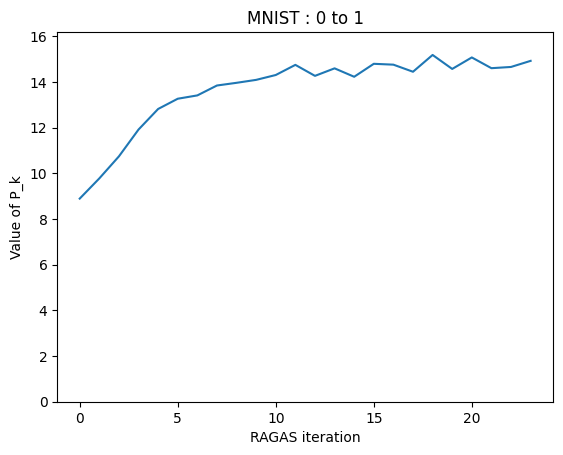

In [ ]:
# plotting the evolution of P_k throughout the iterations of RAGAS /
fig, ax = plt.subplots()
ax.set_ylim([0, max(Ps) + 1])
ax.plot([i for i in range(len(Ps))], Ps)
plt.xlabel('RAGAS iteration')
plt.ylabel('Value of P_k')
plt.title('MNIST : 0 to 1')
plt.show()

__Conclusion on the OT from 0 to 1 : PRW from RGAS and RAGAS coincide after convergence and is lower than W2 and SRW in this high-dimensional setting.__

### Evaluating OT between 0 and 8 with size 128 embeddings 
(=> high-dim. setting when sample size n = 100) 

_We compute W2 first_

In [ ]:
idx = (dataset2.targets == 0) 
zeros = dataset2.data[idx]
out = emb(zeros.type(torch.float).unsqueeze(1).to(device))


#We now filter the images that contain a 8 and apply the embedding representation
idx = (dataset2.targets == 8) 
ones = dataset2.data[idx]
out_ones = emb(ones.type(torch.float).unsqueeze(1).to(device))


x = jnp.asarray(out[:100].cpu().detach().numpy())
y = jnp.asarray(out_ones[:100].cpu().detach().numpy())

r = jnp.ones(100)/100
c = r

print('W2 = ', float(W_2(x/5e2, r, y/5e2, c)))
value_W2 = float(W_2(x/5e2, r, y/5e2, c))

W2 =  22.08884048461914


__Comment__ : We see that W2 is smaller between 0 and 8 than between 0 and 1 : it was expected since it is intuitively easier to transport the shape of 0 into the shape of 8 than to transport the shape of 0 into the shape of 1.

_Computation of SRW_

__NB__ : in case you get RunTimeError raised please try to increase 'reg' parameter below.

In [ ]:
n = x.shape[0]
ones = np.ones((n,n))
C_bis = np.diag(np.diag(x.dot(x.T))).dot(ones) + ones.dot(np.diag(np.diag(y.dot(y.T)))) - 2*x.dot(y.T)

step_size_0 = 1./np.max(C_bis)

params = {'reg':1e2, 'step_size_0':step_size_0, 'max_iter':100, 'threshold':0.01,
          'max_iter_sinkhorn':100, 'threshold_sinkhorn':1e-3, 'use_gpu':False}

algo = FrankWolfe(**params)

SRW_FW = SubspaceRobustWasserstein(x/5e2, y/5e2, r, c, algo, k=50)
SRW_FW.run()

print('SRW =', SRW_FW.get_value())
value_SRW = SRW_FW.get_value()

SRW = 24.197495


__Remark : W2 and SRW should coincide more or less.__

_Computation of PRW with RGAS_

In [ ]:
n = x.shape[0]
d = x.shape[1]
k_star = 50
rng = jax.random.PRNGKey(0)

# hyperparameters of the model
epsilon = 0.001
num_sim = 1000
L1 = approximate_L1(n, d, num_sim)['max']
L2 = approximate_L2(n, d, num_sim)['max']
theta = 1

# INITIALIZATION / we generate a matrix from the stiefel manifold using QR decomposition
A = jax.random.uniform(rng, (d, k_star))
U, R = jnp.linalg.qr(A)

pi, U, Ps = RGAS(x/5e2, r, y/5e2, c, U, epsilon, 
                 C_scaling_factor = 2.5e-5, 
                 stopping_criterion = ['epsilon'])



it 1 || eps : 
0.0017240678
P_k :  6.4726734


it 2 || eps : 
0.0017321169
P_k :  6.6227417


it 3 || eps : 
0.0017488383
P_k :  6.820366


it 4 || eps : 
0.0016898069
P_k :  6.769389


it 5 || eps : 
0.0016992778
P_k :  6.949848


it 6 || eps : 
0.0017098712
P_k :  7.1212173


it 7 || eps : 
0.0017081787
P_k :  7.290791


it 8 || eps : 
0.001696754
P_k :  7.393472


it 9 || eps : 
0.0016827675
P_k :  7.466804


it 10 || eps : 
0.0016384145
P_k :  7.4641986


it 11 || eps : 
0.0016182341
P_k :  7.529113


it 12 || eps : 
0.0015806822
P_k :  7.5348268


it 13 || eps : 
0.0015804113
P_k :  7.685223


it 14 || eps : 
0.0015591962
P_k :  7.7211547


it 15 || eps : 
0.0015364573
P_k :  7.79152


it 16 || eps : 
0.0015310089
P_k :  7.919248


it 17 || eps : 
0.0014925695
P_k :  7.863446


it 18 || eps : 
0.0015020212
P_k :  8.073887


it 19 || eps : 
0.0014695314
P_k :  8.071993


it 20 || eps : 
0.0014597608
P_k :  8.164066


it 21 || eps : 
0.0014396483
P_k :  8.261446


it 22 || eps : 


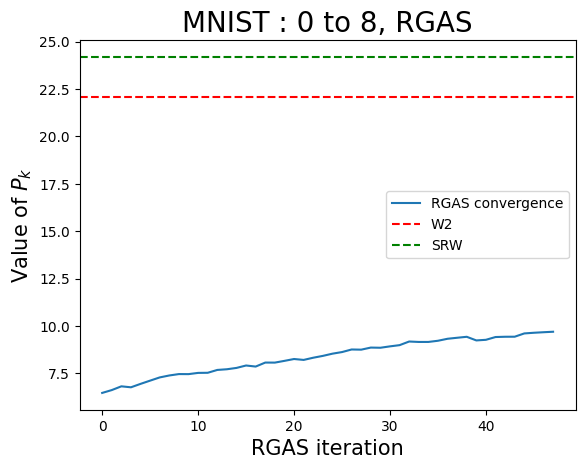

In [ ]:
# plotting the evolution of P_k throughout the iterations of RGAS /
fig, ax = plt.subplots()
# ax.set_ylim([0, max(Ps) + 1])
ax.plot([i for i in range(len(Ps))], Ps, label="RGAS convergence")
ax.axhline(value_W2, color="red", linestyle="--", label="W2")
ax.axhline(value_SRW, color="green", linestyle="--", label="SRW")
plt.xlabel('RGAS iteration', fontsize=15)
plt.ylabel('Value of $P_{k}$', fontsize=15)
plt.title('MNIST : 0 to 8, RGAS', fontsize=20)
plt.legend()
plt.savefig('MNIST : 0 to 8, RGAS')
plt.show()

_Computation of PRW with RAGAS_

In [ ]:
# fragmented hypercube parameters
n = x.shape[0]
d = x.shape[1]
k_star = 50
rng = jax.random.PRNGKey(0)

# hyperparameters of the model
epsilon = 0.001
num_sim = 1000
L1 = 6e-8
L2 = 6e-8
theta = 1 

# INITIALIZATION / we generate a matrix from the stiefel manifold using QR decomposition
A = jax.random.uniform(rng, (d, k_star))
U, R = jnp.linalg.qr(A)

pi, U, Ps = RAGAS(x/5e2, r, y/5e2, c, U, epsilon)



iteration 1
0.0073215845
P_k :  6.9088097


iteration 2
0.0071000946
P_k :  7.3065867


iteration 3
0.0070633315
P_k :  7.886908


iteration 4
0.006584562
P_k :  8.009976


iteration 5
0.0063570174
P_k :  8.373777


iteration 6
0.005947989
P_k :  8.535514


iteration 7
0.005739855
P_k :  8.944837


iteration 8
0.0054539465
P_k :  9.258478


iteration 9
0.0051609664
P_k :  9.529009


iteration 10
0.004790194
P_k :  9.591096


iteration 11
0.0045777513
P_k :  9.919937


iteration 12
0.004241279
P_k :  10.066612


iteration 13
0.003945512
P_k :  10.180923


iteration 14
0.0036180587
P_k :  10.233507


iteration 15
0.0033386194
P_k :  10.2759


iteration 16
0.003083556
P_k :  10.316425


iteration 17
0.0028827803
P_k :  10.509163


iteration 18
0.0027222955
P_k :  10.7063465


iteration 19
0.0024428214
P_k :  10.597624


iteration 20
0.0022966308
P_k :  10.792363


iteration 21
0.002117499
P_k :  10.804557


iteration 22
0.001914722
P_k :  10.680101


iteration 23
0.0018134933
P_k :  10.

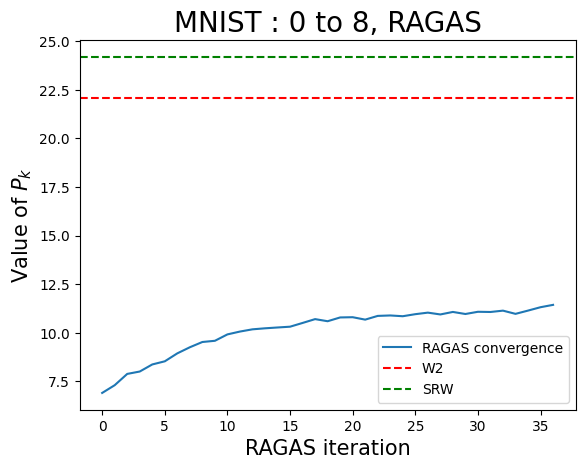

In [ ]:
# plotting the evolution of P_k throughout the iterations of RAGAS /
fig, ax = plt.subplots()
# ax.set_ylim([0, max(Ps) + 1])
ax.plot([i for i in range(len(Ps))], Ps, label="RAGAS convergence")
ax.axhline(value_W2, color="red", linestyle="--", label="W2")
ax.axhline(value_SRW, color="green", linestyle="--", label="SRW")
plt.xlabel('RAGAS iteration', fontsize=15)
plt.ylabel('Value of $P_{k}$', fontsize=15)
plt.title('MNIST : 0 to 8, RAGAS', fontsize=20)
plt.legend()
plt.savefig('MNIST : 0 to 8, RAGAS hello')
plt.show()

__Conclusion on the OT from 0 to 8 : PRW from RGAS and RAGAS coincide after convergence and is lower than W2 and SRW in this high-dimensional setting.__